# ⏲ Conformal Prediction for Time Series with PUNCC

Welcome to this tutorial where we are going to learn how to use PUNCC to conformalize time series models.

If you are new to conformal prediction or PUNCC, we recommend starting with the [**introduction tutorial**](puncc_intro.ipynb)</font> <sub> [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/deel-ai/puncc/blob/main/docs/api_intro.ipynb) </sub> and parse the [basics of conformal prediction theory](https://deel-ai.github.io/puncc/theory_overview.html).

### ⏱️ Why Time Series Is Challenging

In time series forecasting, predictions depend on the **order and relationships** of observations. This introduces two main challenges:
1. **Non-stationarity**: The statistical properties of the data may change over time
2. **Temporal dependencies**: Nearby observations are strongly correlated

This violates the exchangeability assumption (or i.i.d) of traditional conformal prediction.

### 📦 Adapting Conformal Prediction to Time Series 

To deal with these challenges, several extensions of conformal prediction have been proposed in the literature. For example:

- **Sequential calibration** to preserve time ordering (Zaffran et al., 2022)
- **Weighted calibration** to prioritize more relevant calibration examples (Tibshirani et al. 2020, Barber et al., 2023)
- **Adaptive significance tuning** based on observed errors (Adaptive Conformal Inference by Gibbs & Candès)
- **Ensemble-based residual modeling** to handle complex uncertainty and concept drift (Xu & Xie, 2021)

[**PUNCC**](https://github.com/deel-ai/puncc) implements many of these ideas in a unified, easy-to-use API. This tutorial will walk you through three of the most useful methods for conformal prediction on time series.

### 🚀 Methods Covered in This Tutorial

We will focus on the following approaches:

- **OSSCP (Online Sequential Split Conformal Prediction)**: A time-consistent variant of Split Conformal Prediction that respects temporal order and supports online updates.
- **WSCP (Weighted Split Conformal Prediction)**: A flexible method that uses importance weights to account for non-exchangeability.
- **EnbPI (Ensemble batch Prediction Intervals)**: An ensemble-based approach that captures both model and data uncertainty.

### 📋 Choosing the Right Conformal Method for Time Series

Here are some guidelines to help you choose the appropriate method based on your use case and available resources. Feel free to revisit this table after completing the tutorial.

| Method     | When to Use It                                                                 | Strengths                                                  | Limitations                                                | Guarantees                                                  |
|------------|--------------------------------------------------------------------------------|------------------------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| **OSSCP**  | You want to make sequential predictions in streaming or online settings.<br>Time consistency (no future leakage) is required. | ✅ Simple and fast<br>✅ Online updates<br>✅ Time-order aware | ❌ Older data used for calibration may lose relevance | ✅ Reliable prediction intervals when the data shifts over time but remains relatively stable in the short term|
| **WSCP**    | The time series exhibits moderate drift or heterogeneity.<br>You want to prioritize recent or similar calibration points. | ✅ Flexible weighting scheme<br>✅ Improves coverage under drift | ❌ Requires careful weight tuning<br>❌ Assumes weight reliability | ✅ Theoretical bounds on coverage gap tied to distributional shift (TV distance) |
| **EnbPI**  | The data is highly non-stationary or has model/data uncertainty.<br>You can afford training an ensemble. | ✅ Good empirical performance<br>✅ No data splitting | ❌ Computationally expensive<br>❌ Needs ensemble-ready models     | ✅ Valid coverage when the model’s errors behave randomly and don’t stay influenced by older errors (i.e., strongly-mixing residuals and ergodic behavior)|


**Recommendations**:

- Use **OSSCP** as a baseline, especially if you're working in an online or streaming context.
- Prefer **WSCP** if you suspect moderate drift or temporal heterogeneity and can encode this via a well-designed weight function.
- Use **EnbPI** when the data shows complex variability or uncertainty and compute resources are not a bottleneck.


Let's get started !

-----------


## ⏲ The Dataset: Elec2

Elec2 is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

📌 [Vovk et al. (2021)](https://proceedings.mlr.press/v152/vovk21c/vovk21c.pdf) reported the presence of distribution drifts in Elec2, which makes the data non-exchangeable and can invalidate the guarantee of CP marginal coverage.

### Attribute information
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

In [ ]:
import requests
import zipfile
import os
import numpy as np
import pandas as pd

np.random.seed(0)


# download the data from https://www.kaggle.com/yashsharan/the-elec2-dataset
# and save it in the working folder
def download_file(url, local_filename):
    response = requests.get(url)
    with open(f"{local_filename}", "wb") as f:
        f.write(response.content)
    with zipfile.ZipFile(f"{local_filename}", "r") as zip_ref:
        zip_ref.extractall()
    # Remove the zip file
    os.remove(f"{local_filename}")


download_file(
    "https://www.kaggle.com/api/v1/datasets/download/yashsharan/the-elec2-dataset",
    "electricity-normalized.zip",
)

# ELEC2 data set from https://www.kaggle.com/yashsharan/the-elec2-dataset
data = pd.read_csv("electricity-normalized.csv")

data.head(10)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN
5,0.0,2,0.106383,0.041161,0.207528,0.003467,0.422915,0.414912,DOWN
6,0.0,2,0.127660,0.041161,0.171824,0.003467,0.422915,0.414912,DOWN
7,0.0,2,0.148936,0.041161,0.152782,0.003467,0.422915,0.414912,DOWN
8,0.0,2,0.170213,0.041161,0.134930,0.003467,0.422915,0.414912,DOWN
9,0.0,2,0.191489,0.041161,0.140583,0.003467,0.422915,0.414912,DOWN


In [ ]:
# Feature columns
features_col = ["period", "nswprice", "nswdemand", "vicprice", "vicdemand"]

# Target column
target_col = "transfer"

# Remove first sequence where electricity tansfer does not change
data = data.iloc[20000:]

# keep data points for 9:00am - 12:00pm
# each period is measure in half hour intervals over 24 hours and normalized between 0 and 1
time_window_filter = (data.period >= 9 * 2 / 48) & (data.period <= 12 * 2 / 48)
data = data[time_window_filter]

# Cast data to numpy array
X = data[features_col].to_numpy()
y = data[target_col].to_numpy()

## 🧠 Base Model

Now that the data are loaded and preprocessed, we can define the base predictive model.

In this example, we use a **simple linear model** for illustrative purposes. However, you are free to use any model architecture compatible with your task — including neural networks, decision trees, or ensemble methods. PUNCC is designed to be **framework-agnostic**, and it integrates seamlessly with popular machine learning libraries such as **scikit-learn**, **PyTorch**, and **TensorFlow**.

📌 For examples of how to conformalize different model types, refer to the [PUNCC tutorials](https://github.com/deel-ai/puncc?tab=readme-ov-file#-tutorials).


In [ ]:
from sklearn.linear_model import LinearRegression
from deel.puncc.api.prediction import BasePredictor

# Instantiate linear model and wrap it in a BasePredictor
model = LinearRegression()
predictor = BasePredictor(model, is_trained=False)

## 📏 Conformalization

In this section, we guide you through how to use **OSSCP** and **WSCP**, and how to evaluate their performance in terms of **validity** and **efficiency**. 

Since **EnbPI** does not require a dedicated calibration set, we will defer the **full method comparison** to the next section. For now, we present the workflow for the two methods that rely explicitly on split-based calibration.

Here is the workflow:

1. **Instantiate** a conformal predictor wrapper for each method.
2. **Train and calibrate** the base model using **time-aware splits**.
3. **Perform inference** on test data.
4. **Compute metrics**: average prediction interval width (sharpness) and empirical coverage.

To compare both methods, we apply **10-fold time series cross-validation**, which respects temporal ordering — meaning that training always precedes validation in time.

📌 Note: You can easily add other conformal methods or models to this benchmark by following the same workflow.

#### 🛰️ Online Sequential Split Conformal Prediction (OSSCP)

OSSCP adapts the classic split conformal method to time series by respecting temporal order:
- It trains a model on past data and calibrates using more recent—but still past—observations.
- It then predicts for the next point in time, updating the calibration set incrementally.

In practice, OSSCP in PUNCC reuses the `SplitCP` class. The difference lies in **how we update the calibration data over time** — and potentially retrain the model — rather than modifying the conformal algorithm itself.

In [4]:
from deel.puncc.regression import SplitCP

## OSSCP
osscp = SplitCP(predictor, train=True)

#### ⚖️ Weighted Split Conformal Prediction (WSCP)

WCP is a generalization of conformal prediction that uses **importance weights** on calibration data:
- These weights reflect how relevant each past sample is to the current prediction (e.g., via recency or similarity).
- The prediction interval is built using a **weighted quantile** of residuals.

In this tutorial, we’ll use an **exponential decay function** to capture the intuition that **recent observations are more relevant**.

In practice, we still rely on the `SplitCP` class from PUNCC. The key difference is that we provide a custom `weight_func` to assign dynamic importance weights to the calibration residuals.

In [ ]:
from deel.puncc.regression import SplitCP


### Weight function
def exp_decay(X):
    return [0.99 ** (len(X) + 1 - i) for i in range(len(X))]


## WSCP
weighted_split_cp = SplitCP(predictor, weight_func=exp_decay, train=True)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from deel.puncc.metrics import regression_mean_coverage, regression_sharpness
from deel.puncc.plotting import plot_prediction_intervals
import matplotlib.pyplot as plt


tscv = TimeSeriesSplit(n_splits=10)


def train_evaluate(conformal_predictor, tscv, train_size=0.5, alpha=0.1):
    coverages = []
    average_lenghts = []
    # Train the model
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        fit_size, calib_size = int(train_size * len(X_train)), int(
            1 - train_size * len(X_train)
        )
        X_fit, X_calib, y_fit, y_calib = (
            X_train[:fit_size],
            X_train[fit_size:],
            y_train[:fit_size],
            y_train[fit_size:],
        )
        conformal_predictor.fit(
            X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib
        )
        y_pred, y_pred_lower, y_pred_upper = conformal_predictor.predict(
            X_test, alpha=alpha
        )
        coverages.append(
            regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
        )
        average_lenghts.append(regression_sharpness(y_pred_lower, y_pred_upper))

    coverages = np.array(coverages)
    print(f"Mean coverage: {coverages.mean():.3f}")
    print(f"Coverage std: {coverages.std():.3f}")

    average_lenghts = np.array(average_lenghts)
    print(f"Mean sharpness: {average_lenghts.mean():.3f}")
    print(f"Sharpness std: {average_lenghts.std():.3f}")

    plot_prediction_intervals(
        y_test, y_pred_lower, y_pred_upper, y_pred=y_pred, title="SplitCP"
    )
    plt.show()

 ====================== OSSCP ======================
Mean coverage: 0.914
Coverage std: 0.067
Mean sharpness: 0.513
Sharpness std: 0.048


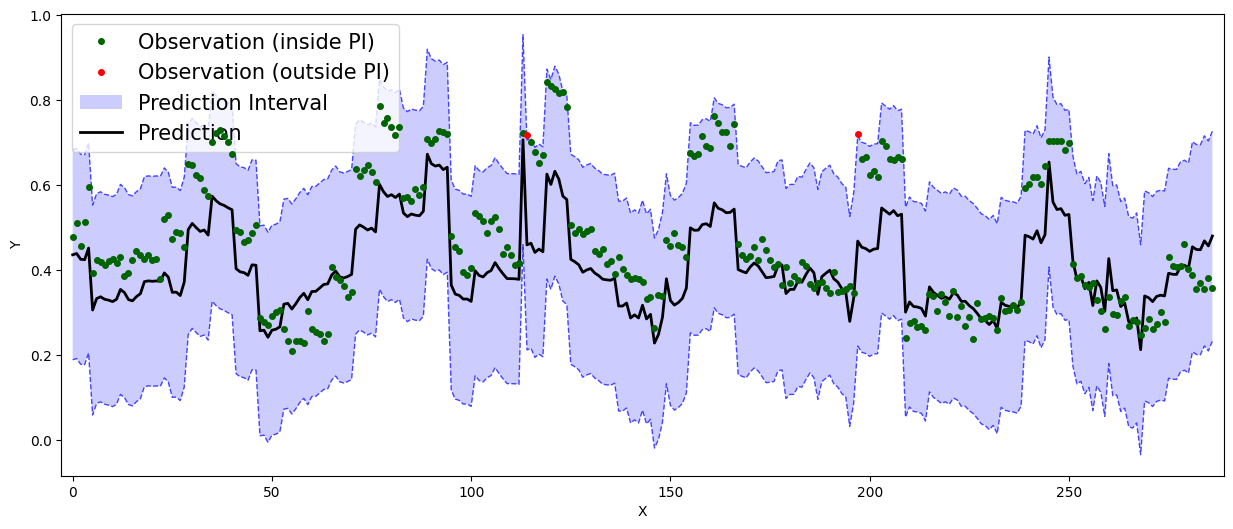

In [7]:
print(" ====================== OSSCP ======================")
train_evaluate(osscp, tscv, train_size=0.3, alpha=0.1)

====================== Weighted SplitCP ======================
Mean coverage: 0.902
Coverage std: 0.050
Mean sharpness: 0.489
Sharpness std: 0.094


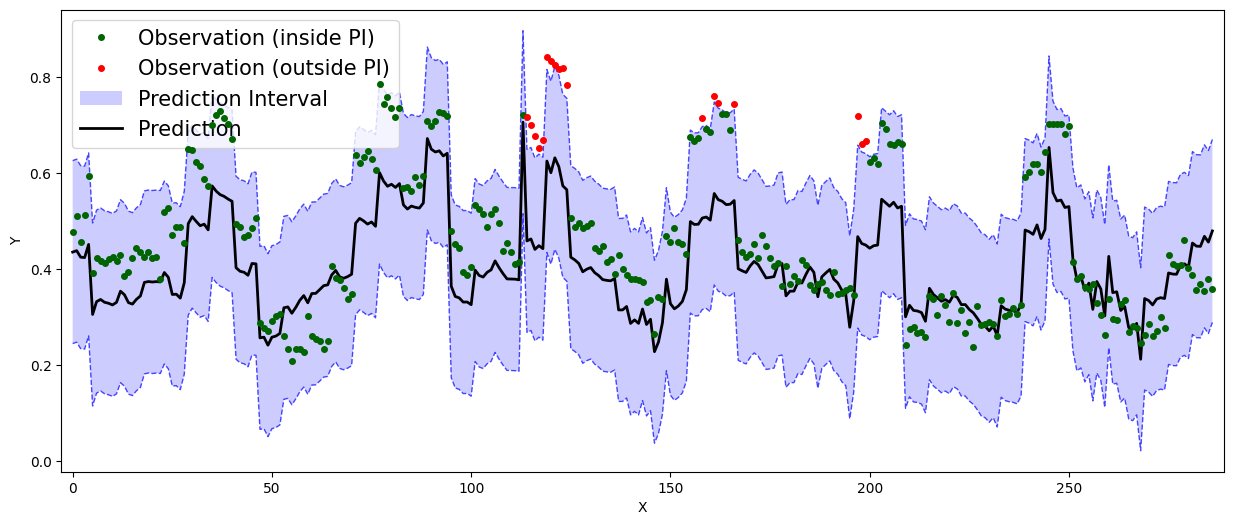

In [8]:
print("====================== Weighted SplitCP ======================")
train_evaluate(weighted_split_cp, tscv, train_size=0.3, alpha=0.1)

Notice that both **OSSCP** and **WSCP** achieve **marginal validity**, meaning their empirical coverage aligns closely with the target confidence level of 90%. OSSCP tends to be slightly more conservative, resulting in **wider intervals**, while WCP provides tighter predictions due to its adaptive weighting.

That said, this trade-off is **not universal** — it depends on the characteristics of the dataset and the underlying model. In our case, the distributional drift is moderate and gradual, which allows both methods to maintain valid marginal coverage. However, in more volatile or rapidly changing time series, **coverage guarantees may no longer hold**.

#### 🧪 Ensemble Batch Prediction Intervals (EnbPI)

EnbPI leverages bootstrapped ensembles to capture both **data uncertainty** and **model variability**:
- It trains multiple models on resampled data.
- Prediction intervals are built from residuals aggregated across ensemble members.


We’ll use the `EnbPI` class provided by PUNCC. Key parameters include:
- `B`: the number of bootstrapped models to train.
- `agg_func_loo`: the function used to **aggregate predictions** from the ensemble (e.g., mean or quantile).

Internally, the wrapped base predictor is **replicated `B` times**, and each copy is trained on a bootstrapped version of the dataset. 

In [9]:
from deel.puncc.regression import EnbPI

## EnbPI
enbpi = EnbPI(predictor, B=20, random_state=0)


### 🔍 Local Performance: Conditional Coverage

Marginal (global) coverage can sometimes hide important details — especially when coverage varies significantly across different time periods, signal levels, or event types.

To assess this, we now look at **a more conditional (or local) coverage** by computing metrics over **sliding evaluation windows**. This allows us to evaluate how well each method maintains coverage **locally over time**, and to detect any performance degradation due to **distributional shift or structural changes** in the series.

In the following, the coverage and interval width are computed using a **sliding window of 100 points** to analyze the local behavior of each of the three methods over time.


<div align="center">
<img src="assets/data_partition.png"/>
<figcaption>
Data partition used for WSCP and OSSCP (left) and EnbPI (right) from <a href="https://proceedings.mlr.press/v204/mendil23a/mendil23a.pdf">Mendil et al.</a>
</figcaption>
</div>

In [ ]:
from tqdm import tqdm
from deel.puncc.metrics import regression_mean_coverage, regression_sharpness

results = []

# Target error rate
alpha = 0.1

# Increment to update sliding windows
counter = 0

# Size of the training set
time_lag = 100

# time_lag + length give total size of the used data
length = 700

for test_index in tqdm(range(time_lag + 100, time_lag + length)):
    # Partition data into fit, calibration and test
    X_fit, y_fit = X[: time_lag + counter], y[: time_lag + counter]
    X_calib, y_calib = (
        X[time_lag + counter : test_index],
        y[time_lag + counter : test_index],
    )
    X_calib, y_calib = (
        X[time_lag + 1 : test_index],
        y[time_lag + 1 : test_index],
    )
    X_test, y_test = X[test_index], y[test_index]

    # OSSCP: fit, predict and metrics
    osscp.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib)
    y_pred_scp, y_pred_lower_scp, y_pred_upper_scp = osscp.predict(
        X_test[np.newaxis, ...], alpha=alpha
    )
    coverage_scp = regression_mean_coverage(
        y_test, y_pred_lower_scp, y_pred_upper_scp
    )
    width_scp = regression_sharpness(y_pred_lower_scp, y_pred_upper_scp)
    results.append(
        [
            "OSSCP",
            test_index,
            float(y_pred_scp),
            y_pred_lower_scp,
            y_pred_upper_scp,
            coverage_scp,
            width_scp,
        ]
    )

    # WSCP: fit, predict and metrics
    weighted_split_cp.fit(
        X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib
    )
    (
        y_pred_wscp,
        y_pred_lower_wscp,
        y_pred_upper_wscp,
    ) = weighted_split_cp.predict(X_test[np.newaxis, ...], alpha=alpha)
    coverage_wscp = regression_mean_coverage(
        y_test, y_pred_lower_wscp, y_pred_upper_wscp
    )
    width_wscp = regression_sharpness(y_pred_lower_wscp, y_pred_upper_wscp)
    results.append(
        [
            "Weighted split CP",
            test_index,
            float(y_pred_wscp),
            y_pred_lower_wscp,
            y_pred_upper_wscp,
            coverage_wscp,
            width_wscp,
        ]
    )

    # EnbPI: fit, predict and metrics
    enbpi.fit(X[counter:test_index], y[counter:test_index])
    y_pred_enbpi, y_pred_lower_enbpi, y_pred_upper_enbpi = enbpi.predict(
        X_test[np.newaxis, ...], alpha=alpha
    )
    coverage_enbpi = regression_mean_coverage(
        y_test, y_pred_lower_enbpi[0], y_pred_upper_enbpi[0]
    )
    width_enbpi = regression_sharpness(
        y_pred_lower_enbpi[0], y_pred_upper_enbpi[0]
    )
    results.append(
        [
            "EnbPI",
            test_index,
            y_pred_enbpi[0],
            y_pred_lower_enbpi[0],
            y_pred_upper_enbpi[0],
            coverage_enbpi,
            width_enbpi,
        ]
    )

    # Update sliding window increment
    counter += 1

columns = [
    "method",
    "time",
    "y_pred",
    "y_pred_lower",
    "y_pred_upper",
    "coverage",
    "width",
]
results_df = pd.DataFrame(results, columns=columns)
y_test = y[np.arange(time_lag + 100, time_lag + length)]

100%|██████████| 600/600 [00:45<00:00, 13.32it/s]


In [11]:
results_df.groupby(["method"])[["coverage", "width"]].mean()

,coverage,width
method,,
EnbPI,0.90,0.319347
OSSCP,0.84,0.364155
Weighted split CP,0.89,0.405216


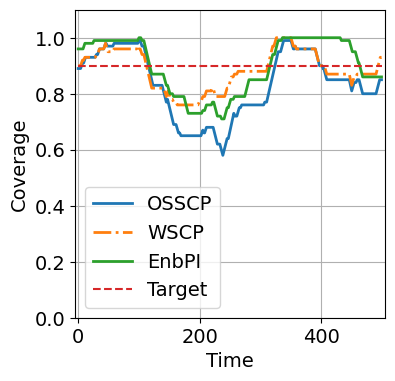

In [12]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# import scienceplots
plt.style.use(['fast'])
# Edit the font, font size, and axes width
plt.rcParams['font.size'] = 14

window = 100

fig, ax = plt.subplots(figsize=(4,4))

def moving_average(y,window):
    return np.convolve(y,np.ones(window)/window)[(window-1):-window]
    
coverage_osscp_ts = results_df[results_df.method == "OSSCP"].coverage
coverage_wscp_ts = results_df[results_df.method == "Weighted split CP"].coverage
coverage_enbpi_ts = results_df[results_df.method == "EnbPI"].coverage

%matplotlib inline
ax.plot(moving_average(coverage_osscp_ts, window), label="OSSCP", linewidth=2)
ax.plot(moving_average(coverage_wscp_ts, window), "-.", label="WSCP", linewidth=2)
ax.plot(moving_average(coverage_enbpi_ts, window), label="EnbPI", linewidth=2)
ax.plot((1-alpha)*np.ones_like(moving_average(coverage_enbpi_ts, window)), "--", label="Target")
ax.set_xlim([-5,505])
ax.set_ylim([0,1.1])
ax.set_xlabel("Time")
ax.set_ylabel("Coverage")

ax.legend()

plt.grid()
plt.show()

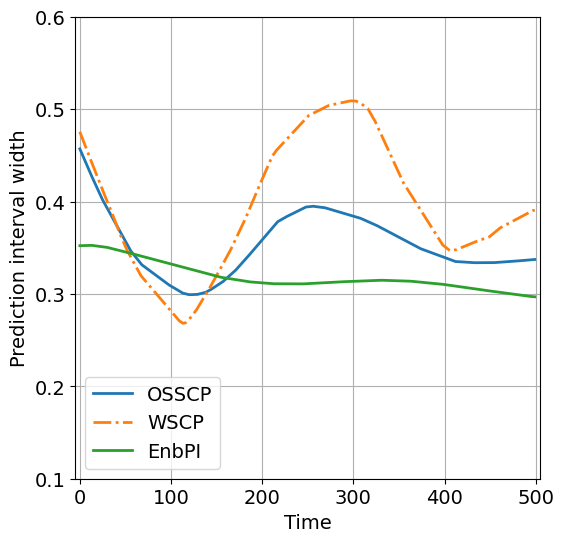

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.style.use(["fast"])
# Edit the font, font size, and axes width
plt.rcParams["font.size"] = 14

window = 100

fig, ax = plt.subplots(figsize=(6, 6))


def moving_average(y, window):
    return np.convolve(y, np.ones(window) / window)[(window - 1) : -window]


width_osscp_ts = results_df[results_df.method == "OSSCP"].width
width_wscp_ts = results_df[results_df.method == "Weighted split CP"].width
width_enbpi_ts = results_df[results_df.method == "EnbPI"].width

ax.plot(moving_average(width_osscp_ts, window), label="OSSCP", linewidth=2)
ax.plot(moving_average(width_wscp_ts, window), "-.", label="WSCP", linewidth=2)
ax.plot(moving_average(width_enbpi_ts, window), label="EnbPI", linewidth=2)
ax.set_xlim([-5, 505])
ax.set_ylim([0.1, 0.6])
ax.legend(loc="lower left")
ax.set_xlabel("Time")
ax.set_ylabel("Prediction interval width")

plt.grid()
plt.show()

The results reveal that **WCSP** and **EnbPI** exhibit greater **resilience to coverage degradation**, especially compared to **OSSCP**, which experiences a significant drop in coverage — reaching levels as low as **60%** at certain time points.

- **WSCP** manages to **adaptively inflate** its prediction intervals in response to drift, allowing it to **recover coverage** effectively.
- **EnbPI**, in contrast, maintains **steady interval widths**, but benefits from a **more stable ensemble predictor**, which is less prone to overfitting due to its use of bootstrapped training subsets. This results in a **better approximation of conditional coverage** under drift.


Let's display a visual comparison of the prediction intervals on 600 test points, generated using the PUNCC plotting module.

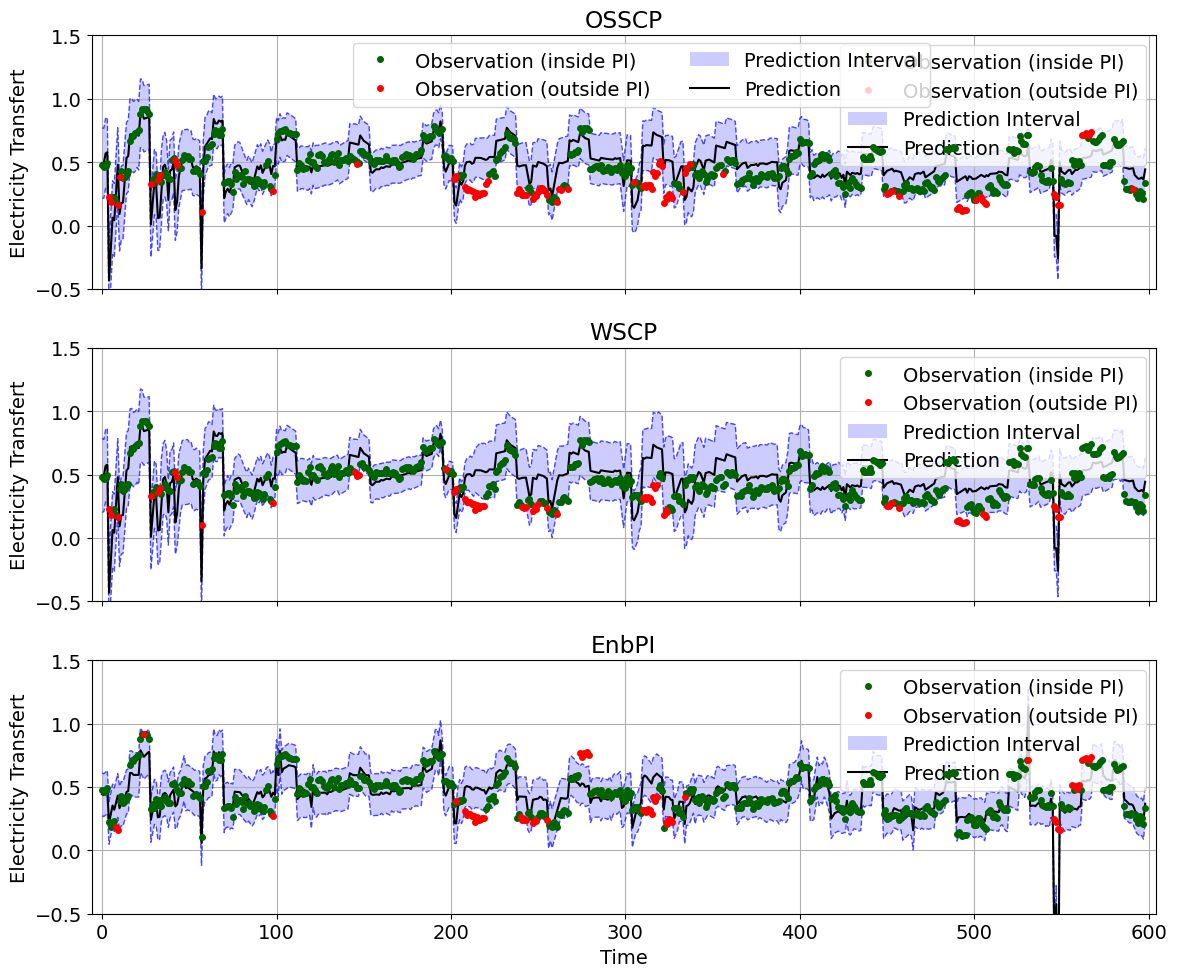

In [ ]:
import matplotlib.pyplot as plt
from deel.puncc.plotting import plot_prediction_intervals

# Recover point and interval prediction for the three methods:

## OSSCP
y_pred_scp = results_df[results_df.method == "OSSCP"].y_pred.values
y_pred_lower_scp = results_df[results_df.method == "OSSCP"].y_pred_lower.values
y_pred_upper_scp = results_df[results_df.method == "OSSCP"].y_pred_upper.values

## WSCP
y_pred_wscp = results_df[results_df.method == "Weighted split CP"].y_pred.values
y_pred_lower_wscp = results_df[
    results_df.method == "Weighted split CP"
].y_pred_lower.values
y_pred_upper_wscp = results_df[
    results_df.method == "Weighted split CP"
].y_pred_upper.values

## EnbPI
y_pred_enbpi = results_df[results_df.method == "EnbPI"].y_pred.values
y_pred_lower_enbpi = results_df[
    results_df.method == "EnbPI"
].y_pred_lower.values
y_pred_upper_enbpi = results_df[
    results_df.method == "EnbPI"
].y_pred_upper.values

horizon = -1

fig, axes = plt.subplots(nrows=3, figsize=(12, 10), sharex=True)

plot_prediction_intervals(
    y_test[:horizon],
    y_pred_lower_scp[:horizon],
    y_pred_upper_scp[:horizon],
    y_pred=y_pred_scp[:horizon],
    ax=axes[0],
    loc="upper right",
)
axes[0].set_xlabel("")
axes[0].set_title("OSSCP")
axes[0].set_ylabel("Electricity Transfert")
axes[0].set_ylim([-0.5, 1.5])

plot_prediction_intervals(
    y_test[:horizon],
    y_pred_lower_wscp[:horizon],
    y_pred_upper_wscp[:horizon],
    y_pred=y_pred_wscp[:horizon],
    ax=axes[1],
    loc="upper right",
)
axes[1].set_xlabel("")
axes[1].set_title("WSCP")
axes[1].set_ylabel("Electricity Transfert")
axes[1].set_ylim([-0.5, 1.5])

plot_prediction_intervals(
    y_test[:horizon],
    y_pred_lower_enbpi[:horizon],
    y_pred_upper_enbpi[:horizon],
    y_pred=y_pred_enbpi[:horizon],
    ax=axes[2],
    loc="upper right",
)
plt.ylim([-1, 2])
axes[2].set_xlabel("Time")
axes[2].set_title("EnbPI")
axes[2].set_ylabel("Electricity Transfert")
axes[2].set_ylim([-0.5, 1.5])

plt.tight_layout()

plt.rcParams["font.size"] = 14

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.3, 0.89), ncol=2)
plt.rcParams["font.family"] = "Times New Roman"

axes[0].grid()
axes[1].grid()
axes[2].grid()

plt.savefig("ts_regression_plot.pdf")

## 🎉 Congratulations

You are now familiar with how to use **PUNCC** to conformalize time series models using **OSSCP**, **WCP**, and **EnbPI**!

Keep in mind that the choice of method depends on your **computational resources**, **model complexity**, and the **degree of non-stationarity** in your data — with coverage guarantees that vary accordingly.

For more examples and advanced use cases, check out the official [PUNCC tutorials](https://github.com/deel-ai/puncc?tab=readme-ov-file#-tutorials).

🚀 You're now ready to build and evaluate your own conformal predictors for real-world time series applications!
